In [5]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import logging
import warnings
import random
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from icecream import ic

from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import Scaler
# from darts.datasets import AirPassengersDataset, ElectricityDataset, MonthlyMilkDataset
from darts.metrics import mae, mape
from darts.models import (
    BlockRNNModel,
    NBEATSModel,
)
from darts.utils.callbacks import TFMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.preprocessing import MinMaxScaler, StandardScaler


# from torch.optim import AdamW

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

#### Many TFM arguments for controlling fitting and instrumentation

In [14]:
# log_dir = r"/workspaces/darts/examples/darts_logs/fit_air/logs"
# sub_dir = "100_32"
# tensorboard_logger = TensorBoardLogger(save_dir=log_dir, name=sub_dir)

# pl_trainer_kwargs = {
#     "accelerator": "cpu",
#     "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
#     "logger": tensorboard_logger,
# }

# # Import AdamW optimizer
# from torch.optim import AdamW

# model_fit_air = NBEATSModel(
#     input_chunk_length=24,
#     output_chunk_length=12,
#     n_epochs=50,
#     batch_size=32,
#     optimizer_cls=AdamW,  # Specify AdamW optimizer
#     optimizer_kwargs={"lr": 1e-3, "weight_decay": 1e-1},
#     random_state=0,
#     log_tensorboard=True,
#     model_name="fit_air",    
#     pl_trainer_kwargs=pl_trainer_kwargs,
# )

# model_fit_air.fit(air_train, val_series=air_val, verbose=True)


In [15]:
raw_data_path = Path("../datasets")
scaler_path = Path("../datasets/scalers")
scaled_data_path = Path("../datasets/scaled")
train_data_path = Path("../datasets/train")
val_data_path = Path("../datasets/val")

def load_data_file(filename, relative_path):
    file_path = relative_path / filename
    df = pd.read_csv(file_path, header=0, index_col="Month", parse_dates=True, dtype=np.float32)
    df = df.asfreq('MS')
    series = TimeSeries.from_dataframe(df)    
    return series

def save_series_to_csv(series, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    series.to_csv(file_path)

def create_scaler(scaler, name):
    if scaler == "MinMaxScaler":
        return Scaler(scaler=MinMaxScaler(feature_range=(0, 1)), name=name)
    elif scaler == "StandardScaler":
        return Scaler(scaler=StandardScaler(), name=name)
    
def save_scaler(scaler, filename, relative_path):
    file_path = relative_path / filename
    file_path.parent.mkdir(parents=True, exist_ok=True)    
    with open(file_path, 'wb') as f:
        pickle.dump(scaler, f)

def load_scaler(filename, relative_path):
    file_path = relative_path / filename
    with open(file_path, 'rb') as f:
        scaler = pickle.load(f)
    return scaler    


1. Load raw data files
2. Create scalars and series
3. Save scalars and series to files
4. Delete large memory objects, as we are simulating having to read from files when multiple series are too big for memory

In [ ]:
air_series_raw = load_data_file("AirPassengers.csv", raw_data_path)
air_scaler = create_scaler("MinMaxScaler", "air")
air_scaler = air_scaler.fit(air_series_raw)
air_series_scaled = air_scaler.transform(air_series_raw)
save_scaler(air_scaler, "air.pkl", scaler_path)
save_series_to_csv(air_series_scaled, "AirPassengers.csv", scaled_data_path)
air_train, air_val = air_series_scaled[:-36], air_series_scaled[-36:]
save_series_to_csv(air_train, "air_train.csv", train_data_path)
save_series_to_csv(air_val, "air_val.csv", val_data_path)

milk_series_raw = load_data_file("monthly-milk.csv", raw_data_path)
milk_scaler = create_scaler("MinMaxScaler", "milk")
milk_scaler = milk_scaler.fit(milk_series_raw)
milk_series_scaled = milk_scaler.transform(milk_series_raw)
save_scaler(milk_scaler, "milk.pkl", scaler_path)
save_series_to_csv(milk_series_scaled, "monthly-milk.csv", scaled_data_path)
milk_train, milk_val = milk_series_scaled[:-36], milk_series_scaled[-36:]                
save_series_to_csv(milk_train, "milk_train.csv", train_data_path)
save_series_to_csv(milk_val, "milk_val.csv", val_data_path)

del air_scaler
del air_series_scaled
del air_train
del air_val

del milk_scaler
del milk_series_scaled
del milk_train
del milk_val

Verify scalars and scaled series from files

ic| air_scaler: air
ic| milk_scaler: milk


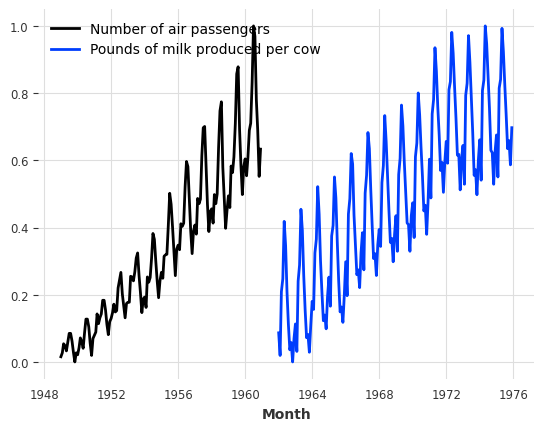

In [ ]:
air_scaler = load_scaler("air.pkl", scaler_path)
ic(air_scaler)
air_series_scaled = load_data_file("AirPassengers.csv", scaled_data_path)

milk_scaler = load_scaler("milk.pkl", scaler_path)
ic(milk_scaler)
milk_series_scaled = load_data_file("monthly-milk.csv", scaled_data_path)

air_series_scaled.plot(label="Number of air passengers")
milk_series_scaled.plot(label="Pounds of milk produced per cow")
plt.legend()
plt.show()

del air_scaler
del air_series_scaled
del milk_scaler
del milk_series_scaled  

Verify train and val from files

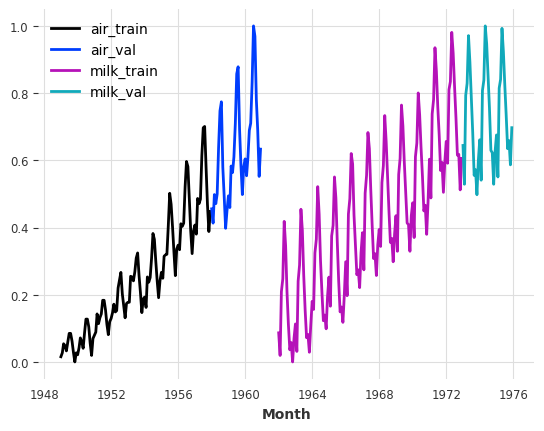

In [19]:
air_train = load_data_file("air_train.csv", train_data_path)
air_val = load_data_file("air_val.csv", val_data_path)

milk_train = load_data_file("milk_train.csv", train_data_path)
milk_val = load_data_file("milk_val.csv", val_data_path)

air_train.plot(label="air_train")
air_val.plot(label="air_val")
milk_train.plot(label="milk_train")
milk_val.plot(label="milk_val")
plt.legend();
plt.show()

del air_train
del air_val

del milk_train
del milk_val